In [2]:
try:
    import pymc as pm
except:
    %pip install pymc==5.8.0    
    import pymc as pm
    
print(pm.__version__)

try:
    import pymc_bart as pmb
except:
    %pip install pymc-bart
    import pymc_bart as pmb
    

print(pmb.__version__)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import os
import pickle

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


5.8.0
0.5.1


In [3]:
# configure training/testing environment
tree_fname = 'BART_simple_forest.pkl' # filename
data_fname = 'BART_simple_data.pkl'

generate_and_save_data = 0 # otherwise load data
train_model = 1
save_model = 1 # otherwise load model
pred_data = 1

# useful functions
def get_predictions_from_trees(forests, x_te):
    # sample from each forest in forests
    # forests is a list of a list.
    # the outer list contains each forest
    # each forest contains trees. Average predictions from each tree in a forest, output each forest prediction
    # output is x_te.shape[0] x N_forests
    
    pred_out = np.zeros((x_te.shape[0], len(forests)))
    for i_forest in range(len(forests)):
        trees = forests[i_forest]
        temp_pred = 0
        for tree in trees:
            temp_pred += tree.predict(x_te)
        pred_out[:,i_forest] = temp_pred
    return pred_out

def invlogit(x):
    return 1/(1+np.exp(-x))

def sample_posterior(forests, x_te):
    forest_pred = get_predictions_from_trees(forests,x_te)
    return invlogit(forest_pred)

Only 5 samples in chain.
Sequential sampling (2 chains in 1 job)
PGBART: [mu]


Sampling 2 chains for 2 tune and 5 draw iterations (4 + 10 draws total) took 20 seconds.
The number of samples is too small to check convergence reliably.
Sampling: []


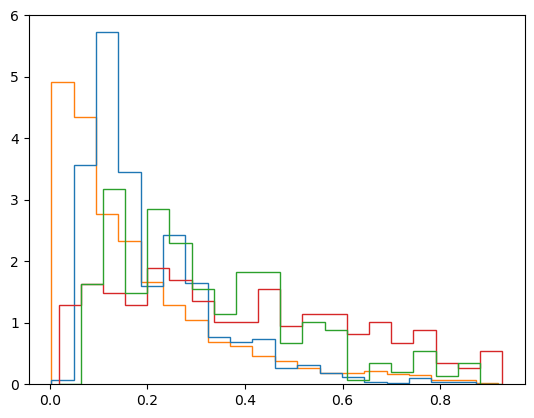

In [4]:
if generate_and_save_data:
    n1 = 1550 # n in each class
    n2 = 500
    n_dim = 10

    mean1 = 1
    std1 = 1
    mean2 = 1.5
    std2 = 1

    x1 = np.random.randn(n1,n_dim)*std1 + mean1
    y1 = np.zeros((n1,))
    x2 = np.random.randn(n2,n_dim)*std2 + mean2
    y2 = np.ones((n2,))

    x_in = np.concatenate((x1,x2),axis=0)
    y_in = np.concatenate((y1,y2),axis=0)

    x_tr, x_te, y_tr, y_te = train_test_split(x_in, y_in, test_size=0.33)

    plt.figure()
    plt.hist(x1[:,0],bins=20,histtype='step',density=True);
    plt.hist(x2[:,0],bins=20,histtype='step',density=True);

    with open(data_fname,'wb') as f:
        pickle.dump({'x_tr':x_tr,'y_tr':y_tr,'x_te':x_te,'y_te':y_te},f)
    
else:
    with open(data_fname,'rb') as f:
        data = pickle.load(f)
        
    x_tr = data['x_tr']
    y_tr = data['y_tr']
    x_te = data['x_te']
    y_te = data['y_te']
    
    
# define and train model
if train_model:
    with pm.Model() as bart_model:
        X = pm.MutableData("X", x_tr, dims=("obs","feature"))
        Y = y_tr
        mu = pmb.BART("mu", X=X, Y=Y, m=10, dims="obs", shape=X.shape[0])
        p = pm.Deterministic('p', pm.math.invlogit(mu), dims="obs")
        pm.Bernoulli("y", p=p, observed=Y, dims="obs",shape=p.shape[0])#shape=p.shape)
        idata_train = pm.sample(tune=2,draws=5,chains=2)
        
        posterior_train = pm.sample_posterior_predictive(trace=idata_train,
                                                              var_names=["p"])
    
    prior_train = prior_train = posterior_train.posterior_predictive.p.mean(axis=1).mean(axis=0).T

    plt.figure()
    plt.hist(prior_train[y_tr==0],histtype='step',bins=20,density=True);
    plt.hist(prior_train[y_tr==1],histtype='step',bins=20,density=True);

In [23]:
forests = []
for i in range(len(pmb.BART.all_trees)):
        trees = []
        for j in range(len(pmb.BART.all_trees[i])):
            for k in range(pmb.BART.all_trees[i][j].shape[0]):
                trees.append(pmb.BART.all_trees[i][j][k])

        forests.append(trees)

In [24]:
if pred_data:
    x_in = x_tr
    y_in = y_tr
    
    pred_per_forest = sample_posterior(forests,x_in)
    pred_mean = np.mean(pred_per_forest,axis=1)

In [6]:
if save_model:
    # extract trees in a nice structure....
    forests = []

    for i in range(len(pmb.BART.all_trees)):
        trees = []
        for j in range(len(pmb.BART.all_trees[i])):
            for k in range(pmb.BART.all_trees[i][j].shape[0]):
                trees.append(pmb.BART.all_trees[i][j][k])

        forests.append(trees)
    
    with open(tree_fname, 'wb') as f:
        pickle.dump({'forests':forests},f)
else:
    with open(tree_fname,'rb') as f:
        forest_data = pickle.load(f)
    forests = forest_data['forests']

[[195 147]
 [  3  51]]


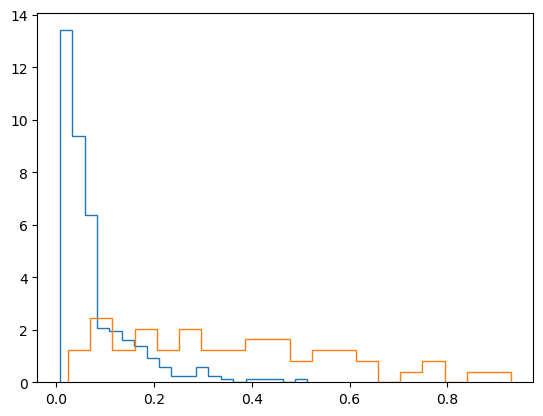

In [7]:
if pred_data:
    x_in = x_te
    y_in = y_te
    
    pred_per_forest = sample_posterior(forests,x_in)
    pred_mean = np.mean(pred_per_forest,axis=1)

    plt.hist(pred_mean[y_in==0],histtype='step',bins=20,density=True);
    plt.hist(pred_mean[y_in==1],histtype='step',bins=20,density=True);
    print(confusion_matrix(y_true=y_te, y_pred=pred_mean>np.percentile(pred_mean,50)))